Tiền xử lý dữ liệu

In [ ]:
# import các thư viện cần thiết
!pip install tensorflow numpy pandas matplotlib opencv-python scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tiền xử lý ảnh với bộ dữ liệu Task 1 2018

In [ ]:
import os
import tensorflow as tf

# Định nghĩa đường dẫn
IMAGE_PATH = "/content/drive/MyDrive/ISIC_2018/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/"
MASK_PATH = "/content/drive/MyDrive/ISIC_2018/ISIC2018_Task1_Training_GroundTruth/"

IMG_SIZE = 256
NUM_IMAGES = 1500
BATCH_SIZE = 16
SEED = 42

# Hàm load 1 cặp ảnh & mask từ đường dẫn
def parse_image_mask(image_path, mask_path):
    # Load ảnh RGB
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    # Load mask grayscale → nhị phân
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    mask = tf.where(mask > 0, 1.0, 0.0)

    return image, mask

# Tạo danh sách đường dẫn ảnh/mask
def get_image_mask_paths(image_dir, mask_dir, num_images):
    filenames = sorted(os.listdir(image_dir))[:num_images]

    image_paths = [os.path.join(image_dir, f) for f in filenames]
    mask_paths = [os.path.join(mask_dir, os.path.splitext(f)[0] + "_segmentation.png") for f in filenames]

    return image_paths, mask_paths

# Tạo tf.data.Dataset từ danh sách ảnh & mask
def build_dataset(image_paths, mask_paths, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=SEED)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Tạo dữ liệu
image_paths, mask_paths = get_image_mask_paths(IMAGE_PATH, MASK_PATH, NUM_IMAGES)

# Chia train/val/test theo 75/15/15
total = len(image_paths)
train_size = int(0.75 * total)
val_size = int(0.15 * total)

train_img = image_paths[:train_size]
train_mask = mask_paths[:train_size]

val_img = image_paths[train_size:train_size + val_size]
val_mask = mask_paths[train_size:train_size + val_size]

test_img = image_paths[train_size + val_size:]
test_mask = mask_paths[train_size + val_size:]

# Tạo datasets
train_ds = build_dataset(train_img, train_mask, BATCH_SIZE, shuffle=True)
val_ds   = build_dataset(val_img, val_mask, BATCH_SIZE, shuffle=False)
test_ds  = build_dataset(test_img, test_mask, BATCH_SIZE, shuffle=False)

# In kiểm tra
print(f"Số ảnh train: {len(train_img)}")
print(f"Số ảnh val:   {len(val_img)}")
print(f"Số ảnh test:  {len(test_img)}")

# Kiểm tra 1 batch (tùy chọn)
for x_batch, y_batch in train_ds.take(1):
    print("Batch ảnh:", x_batch.shape)
    print("Batch mask:", y_batch.shape)


Số ảnh train: 1125
Số ảnh val:   225
Số ảnh test:  150
Batch ảnh: (16, 256, 256, 3)
Batch mask: (16, 256, 256, 1)


Hiển thị một số ảnh và mask tương ứng

In [ ]:
import matplotlib.pyplot as plt

def show_images_and_masks_from_dataset(dataset, num_samples=5):
    # Duyệt dataset từng sample theo batch nhỏ
    for images, masks in dataset.take(1):  # chỉ lấy 1 batch
        plt.figure(figsize=(10, num_samples * 2))

        for i in range(num_samples):
            # Ảnh gốc
            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.imshow(images[i].numpy())
            plt.title("Ảnh")
            plt.axis("off")

            # Mask
            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("Mask")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break  # chỉ hiển thị 1 batch


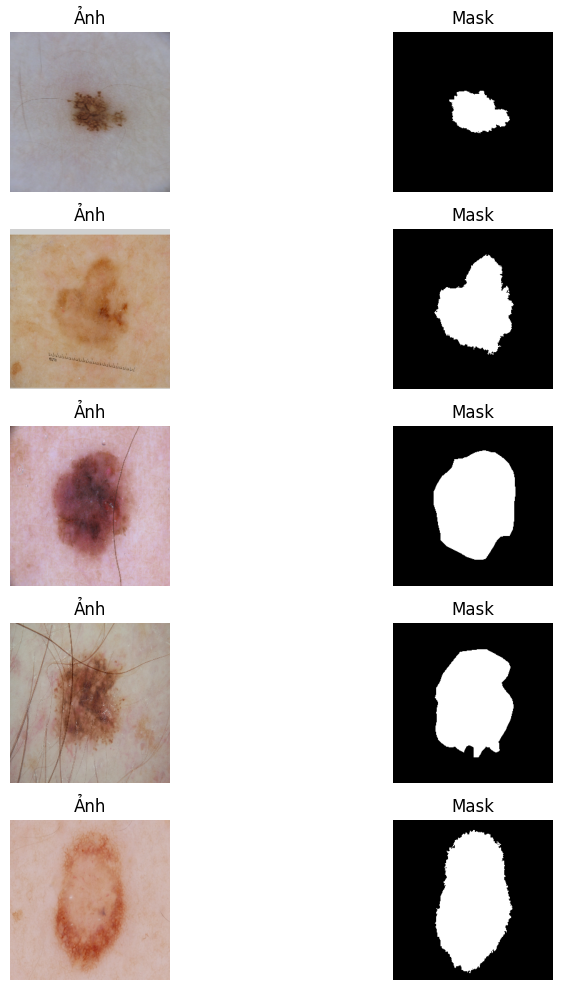

In [ ]:
show_images_and_masks_from_dataset(train_ds)


Xây dựng mô hình U-net


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    up1 = layers.Concatenate()([up1, conv2])

    up2 = layers.UpSampling2D(size=(2, 2))(up1)
    up2 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    up2 = layers.Concatenate()([up2, conv1])

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(up2)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Khởi tạo mô hình
model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    295,040 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ concatenate[0][0] │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │    147,520 │ up_sampling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_7[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        129 │ concatenate_1[0]… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,588,097 (6.06 MB)

 Trainable params: 1,588,097 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện mô hình U-net với 30 epoch độ chính xác 91%

In [ ]:
# Huấn luyện mô hình với tf.data.Dataset
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1
)

# Lưu mô hình
model.save("/content/unet_isic2018.h5")


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.7499 - loss: 0.5440 - val_accuracy: 0.8489 - val_loss: 0.4503
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 74s 695ms/step - accuracy: 0.8388 - loss: 0.4048 - val_accuracy: 0.8652 - val_loss: 0.3570
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.8693 - loss: 0.3451 - val_accuracy: 0.7490 - val_loss: 0.6314
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 67s 593ms/step - accuracy: 0.8769 - loss: 0.3414 - val_accuracy: 0.8143 - val_loss: 0.4205
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 682ms/step - accuracy: 0.8945 - loss: 0.2852 - val_accuracy: 0.8614 - val_loss: 0.3236
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 77s 598ms/step - accuracy: 0.8935 - loss: 0.2819 - val_accuracy: 0.8195 - val_loss: 0.3806
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 71s 683ms/step - accuracy: 0.8925 - loss: 0.2792 - val_accuracy: 0.8190 - val_loss: 0.3655
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 85s 686ms/step - accuracy: 0.8946 - loss: 0.2650 - val_accura

Hiển thị kết quả ảnh gốc, mask gốc, mask thực tế

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


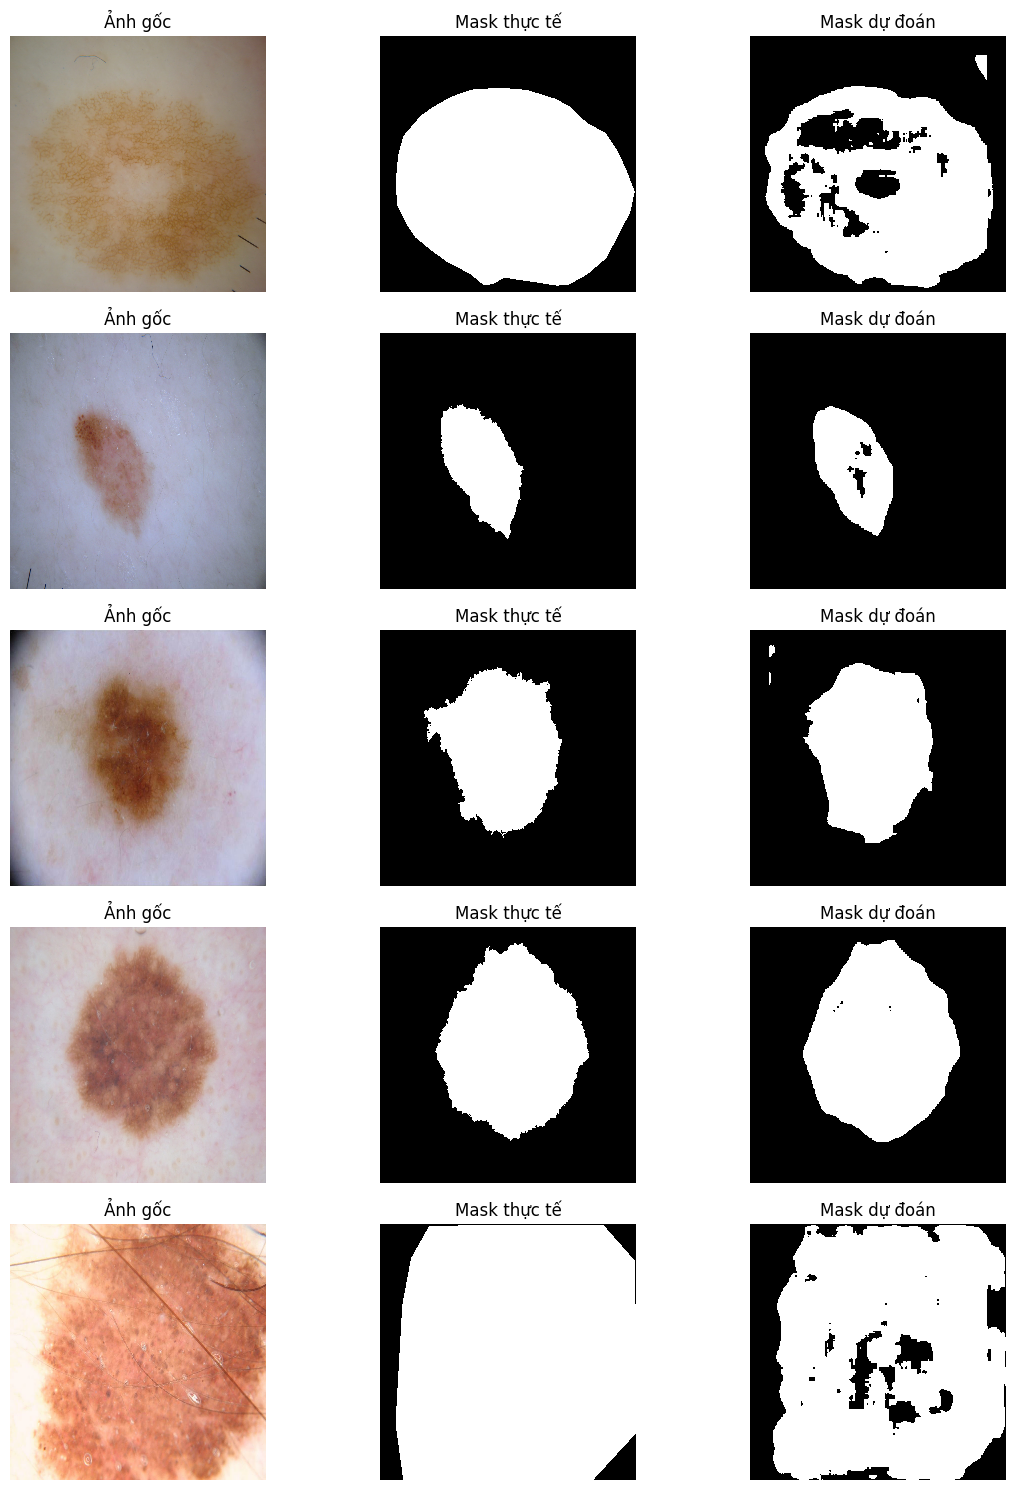

In [ ]:
num_samples = 5
plt.figure(figsize=(12, num_samples * 3))

for i, (images, true_masks) in enumerate(train_ds.take(num_samples)):
    # images: batch shape (B, H, W, C)
    # Lấy ảnh đầu tiên trong batch
    image = images[0]
    true_mask = true_masks[0]

    # Dự đoán mask
    input_img = tf.expand_dims(image, axis=0)  # batch 1 ảnh
    pred_mask = model.predict(input_img)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Hiển thị ảnh gốc
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(image.numpy())
    plt.title("Ảnh gốc")
    plt.axis("off")

    # Hiển thị mask thực tế
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(true_mask.numpy().squeeze(), cmap="gray")
    plt.title("Mask thực tế")
    plt.axis("off")

    # Hiển thị mask dự đoán
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Mask dự đoán")
    plt.axis("off")

plt.tight_layout()
plt.show()
